# Connection to garmin connect with Garth

In [1]:
import garth
import os 
from garth.exc import GarthException

In [2]:
GARMIN_EMAIL = os.getenv("EMAIL")
GARMIN_PASSWORD = os.getenv("PASSWORD")

GARTH_HOME = "~/.garth"

In [3]:
print(GARMIN_EMAIL)

lucas.piquet@centrale.centralelille.fr


Le scrip de requete à l'api de garmin se trouve ici:
https://github.com/matin/garth/blob/main/garth/http.py

In [4]:
try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (FileNotFoundError, GarthException):
    garth.login(GARMIN_EMAIL, GARMIN_PASSWORD)

garth.save(GARTH_HOME)

In [5]:
garth.WeeklyStress.list()[0]

WeeklyStress(calendar_date=datetime.date(2025, 3, 12), value=26)

In [8]:
weekly_stress = garth.WeeklyStress.list(period=104)

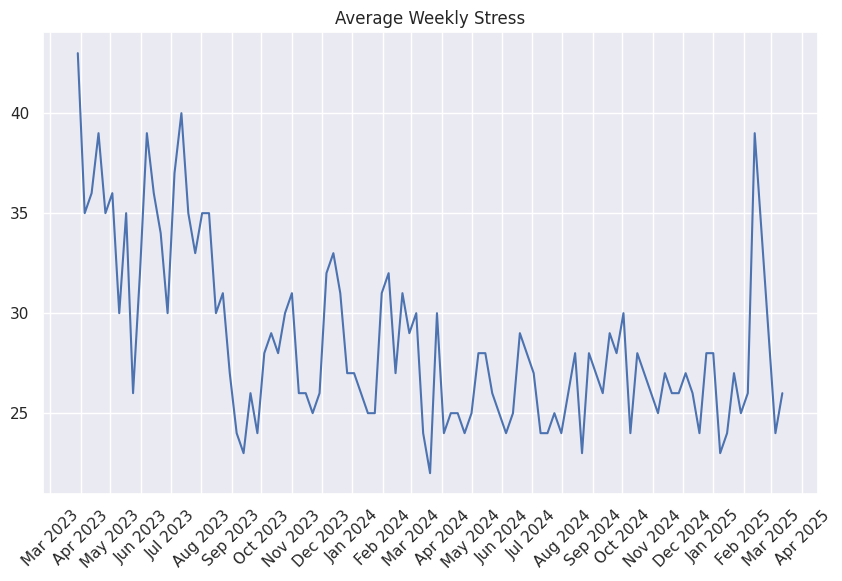

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

df = pd.DataFrame(weekly_stress).sort_values("calendar_date")

sns.set_theme()

plt.figure(figsize=(10, 6))

sns.lineplot(x=df["calendar_date"], y=df["value"])

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)

plt.xlabel(None)
plt.ylabel(None)
plt.title("Average Weekly Stress")

plt.show()

In [10]:
from datetime import date, timedelta

garth.DailyStress.list(date.today() - timedelta(days=1))[0]

DailyStress(calendar_date=datetime.date(2025, 3, 17), overall_stress_level=24, rest_stress_duration=32520, low_stress_duration=12060, medium_stress_duration=240, high_stress_duration=None)

In [11]:
daily_stress = garth.DailyStress.list(period=365 * 3)

In [12]:
len((daily_stress))

692

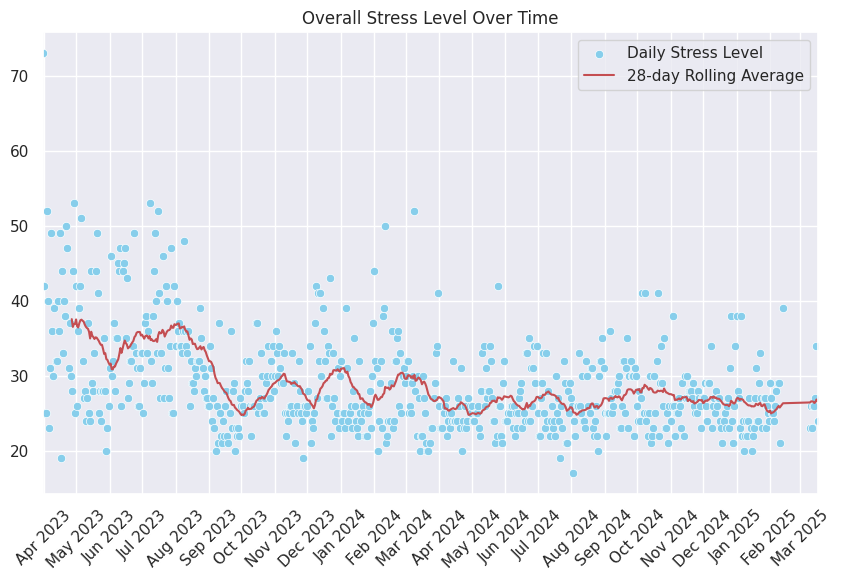

In [13]:
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt

sns.set_theme()

df = pd.DataFrame(daily_stress)
df.set_index("calendar_date", inplace=True)

df["rolling_avg"] = df["overall_stress_level"].rolling(window=28).mean()

plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df.index,
    y=df["overall_stress_level"],
    color="skyblue",
    label="Daily Stress Level"
)

sns.lineplot(
    x=df.index,
    y=df["rolling_avg"],
    color="r",
    label="28-day Rolling Average"
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

plt.xticks(rotation=45)
plt.xlim(df.index.min(), df.index.max())
plt.xlabel(None)
plt.ylabel(None)
plt.title("Overall Stress Level Over Time")
plt.legend()

plt.show()

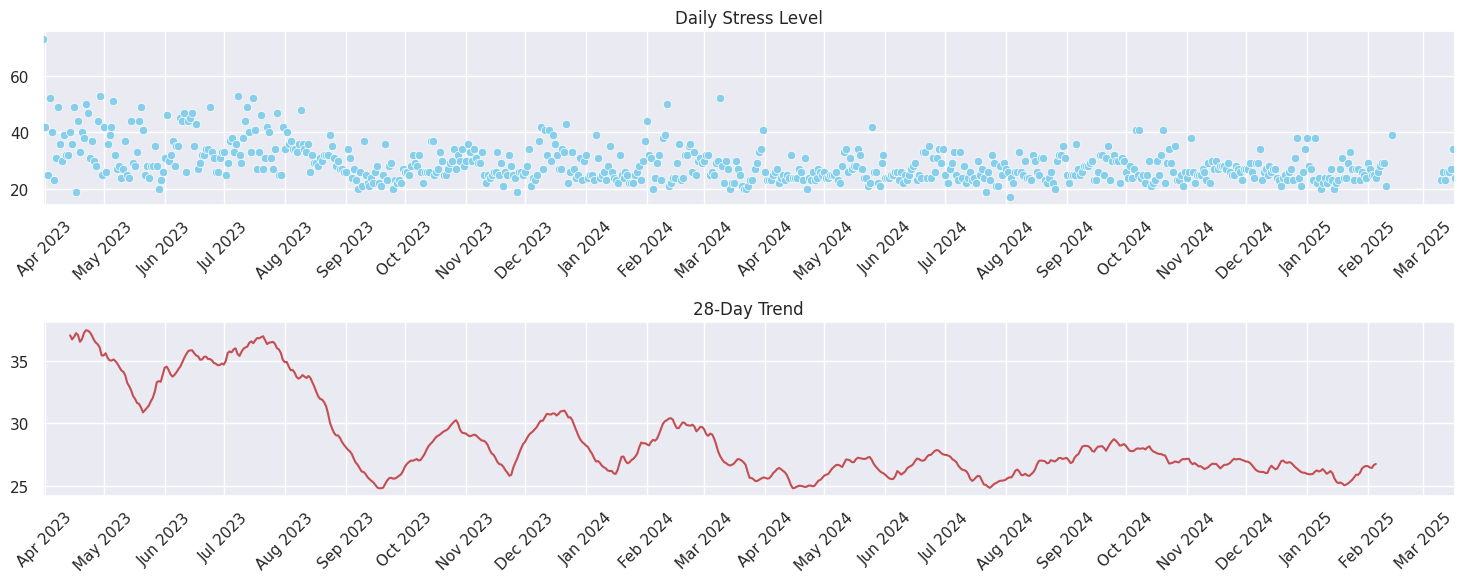

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(
    df["overall_stress_level"], model="additive", period=28
)
trend = result.trend.dropna()

min_date = df.index.min()
max_date = df.index.max()

def plot_subplot(ax, x, y, title, color, plot_type="line"):
    if plot_type == "line":
        sns.lineplot(ax=ax, x=x, y=y, color=color)
    elif plot_type == 'scatter':
        sns.scatterplot(ax=ax, x=x, y=y, color=color)

    ax.set_title(title)
    ax.set_xlim(min_date, max_date)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.tick_params(axis="x", rotation=45)

fig, axes = plt.subplots(2, 1, figsize=(15, 6))

plot_subplot(
    axes[0], df.index, df["overall_stress_level"],
    "Daily Stress Level", "skyblue", plot_type='scatter'
)
plot_subplot(axes[1], trend.index, trend, "28-Day Trend", "r")

plt.tight_layout()
plt.show()


### Manual request to explore garmin API

In [17]:
from requests import Session
from requests.adapters import HTTPAdapter, Retry
from urllib.parse import urljoin


USER_AGENT = {"User-Agent": "GCM-iOS-5.7.2.1"}

# Créer une session
session = Session()
session.headers.update(USER_AGENT)

retry = Retry(
            total=3,
            status_forcelist=(408, 429, 500, 502, 503, 504),
            backoff_factor=0.5,
        )

adapter = HTTPAdapter(
            max_retries=retry,
            pool_connections=10,
            pool_maxsize=10,
        )

session.mount("https://", adapter)

# url = f"{self.garmin_connect_floors_chart_daily_url}/{cdate}"

yesterday = date.today() - timedelta(days=1)
yesterday = yesterday.isoformat()

garmin_connect_floors_chart_daily_url = "/wellness-service/wellness/floorsChartData/daily"

path = f"{garmin_connect_floors_chart_daily_url}/{yesterday}"
url  = urljoin('https://connect_api.garmin.com/', path)
print(url)

# Envoyer une requête GET
response = session.request('GET', 'https://connect_api.garmin.com/', url, timeout=10)

# Afficher le code de statut et le contenu de la réponse
print(response.status_code)
print(response.text)


https://connect_api.garmin.com/wellness-service/wellness/floorsChartData/daily/2025-03-17


ConnectionError: HTTPSConnectionPool(host='connect_api.garmin.com', port=443): Max retries exceeded with url: /?https://connect_api.garmin.com/wellness-service/wellness/floorsChartData/daily/2025-03-17 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7c7f1efc6da0>: Failed to resolve 'connect_api.garmin.com' ([Errno -2] Name or service not known)"))

TO DO: I need authentification credits to connect to the API.